# Exploratory Data Analysis

Exploration with histograms, Entropy, and KL Divergence.

## Imports

In [6]:
from glob import glob
import json
import numpy as np
import pandas as pd
import PIL
import scipy.stats
import skimage.filters.rank 
from skimage.morphology import disk

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style("dark", {'axes.grid' : False})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load merged data

In [7]:
app_ui_df = pd.read_pickle('../clean_data/app_ui_df.pkl')
app_ui_df.shape

(9567, 17)

In [8]:
app_ui_df.head(2)

,app_package_name,app_name,app_category,star_rating,average_rating,number_of_ratings,min_ratings,ui_number,interaction_trace_number,ui_number_in_trace,filename,app_name_num,app_cat_num,star_rating_num,average_rating_num,number_of_ratings_num,filename_num
0,B4A.BigFivePersonalityTest,[Big 5 Personality Test],Education,[3.6],[6698],"[ 1,000,000 - 5,000,000 ]",[1000000],[49783],[0],[221],[../app_uis/49783.jpg],1,1,1,1,1,1
1,CN.MyPrivateMessages,[Calculator],Communication,[4.3],"[17020, 16918, 16919]","[ 1,000,000 - 5,000,000 ]",[1000000],[26083],[0],[15],[../app_uis/26083.jpg],1,1,1,3,1,1


#### Subset to only columns of interest

In [9]:
app_ui_df['app_names'] = app_ui_df.app_name.map(lambda x: ', '.join(x))
app_ui_df['star_rating_ave'] = app_ui_df.star_rating.map(lambda x: np.mean(x))
app_ui_df['average_rating_ave'] = app_ui_df.average_rating.map(lambda x: np.mean(x))
app_ui_df['min_ratings_ave'] = app_ui_df.min_ratings.map(lambda x: np.mean(x))

In [10]:
cols_keep = ['app_package_name', 'app_names', 'app_category', 'star_rating_ave', \
             'average_rating_ave', 'min_ratings_ave', 'filename', 'filename_num']

app_ui_df_clean = app_ui_df[cols_keep]

In [11]:
app_ui_df_clean.head(2)

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename,filename_num
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1


#### Explode filename list into single rows for easy manipulation later

In [12]:
filename_exp = app_ui_df_clean.filename.apply(pd.Series).stack().reset_index(
    level=1, drop=True).to_frame('filename_exp')

In [13]:
filename_exp.shape

(70959, 1)

In [14]:
app_ui_exp = pd.concat([app_ui_df_clean, filename_exp], axis=1)
app_ui_exp.reset_index(drop=True, inplace=True)
app_ui_exp.rename(columns={'filename': 'filename_list'}, inplace=True)
app_ui_exp.shape

(70959, 9)

In [15]:
app_ui_exp.groupby('app_package_name')['app_package_name'].count().shape

(9567,)

In [16]:
app_ui_exp[['app_package_name', 'filename_num']].head(10)

,app_package_name,filename_num
0,B4A.BigFivePersonalityTest,1
1,CN.MyPrivateMessages,1
2,DOCECG2.doctor,1
3,Gecko.Droid.PhysicsHelper,5
4,Gecko.Droid.PhysicsHelper,5
5,Gecko.Droid.PhysicsHelper,5
6,Gecko.Droid.PhysicsHelper,5
7,Gecko.Droid.PhysicsHelper,5
8,HinKhoj.Dictionary,20
9,HinKhoj.Dictionary,20


In [17]:
app_ui_exp.groupby('app_package_name')['app_package_name'].count().head()

app_package_name
B4A.BigFivePersonalityTest     1
CN.MyPrivateMessages           1
DOCECG2.doctor                 1
Gecko.Droid.PhysicsHelper      5
HinKhoj.Dictionary            20
Name: app_package_name, dtype: int64

#### Stats on UI screenshots for app packages

In [18]:
app_ui_df.filename_num.describe()

count    9567.000000
mean        7.417059
std         7.603794
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        76.000000
Name: filename_num, dtype: float64

#### Width, height, aspect ratio for app UIs

In [19]:
app_ui_exp['img_w'] = app_ui_exp.filename_exp.map(lambda x: PIL.Image.open(x).size[0])
app_ui_exp['img_h'] = app_ui_exp.filename_exp.map(lambda x: PIL.Image.open(x).size[1])
app_ui_exp['aspect_ratio'] = (app_ui_exp.img_w / app_ui_exp.img_h)

app_ui_exp.head()

,app_package_name,app_names,app_category,star_rating_ave,average_rating_ave,min_ratings_ave,filename_list,filename_num,filename_exp,img_w,img_h,aspect_ratio
0,B4A.BigFivePersonalityTest,Big 5 Personality Test,Education,3.6,6698.000000,1000000.0,[../app_uis/49783.jpg],1,../app_uis/49783.jpg,1080,1920,0.5625
1,CN.MyPrivateMessages,Calculator,Communication,4.3,16952.333333,1000000.0,[../app_uis/26083.jpg],1,../app_uis/26083.jpg,1080,1920,0.5625
2,DOCECG2.doctor,Electrocardiogram ECG Types,Medical,3.9,4134.500000,500000.0,[../app_uis/51036.jpg],1,../app_uis/51036.jpg,1080,1920,0.5625
3,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[../app_uis/29868.jpg, ../app_uis/29869.jpg, ....",5,../app_uis/29868.jpg,1080,1920,0.5625
4,Gecko.Droid.PhysicsHelper,Pocket Physics,Education,4.1,15938.000000,1000000.0,"[../app_uis/29868.jpg, ../app_uis/29869.jpg, ....",5,../app_uis/29869.jpg,1080,1920,0.5625


In [20]:
app_ui_exp.img_w.value_counts()

1080    53899
540     16949
1920       82
960        29
Name: img_w, dtype: int64

In [21]:
app_ui_exp.img_h.value_counts()

1920    53899
960     16949
1080       82
540        29
Name: img_h, dtype: int64

In [22]:
app_ui_exp.aspect_ratio.value_counts()

0.562500    70848
1.777778      111
Name: aspect_ratio, dtype: int64

#### Save resulting dataframe

In [244]:
app_ui_exp.to_pickle('../clean_data/app_ui_exp.pkl')

## Histograms

An image histogram refers to the probability mass function of the image intensities.
This is extended for color images to capture the joint probabilities of the intensities of the three color channels (R, G, B). 

A pixel's intensity value can range between 0 (black) and 255 (white). A histogram represents the occurrence/frequency of these particular intensity values.

In [239]:
def pil_img(filepath):
    return PIL.Image.open(filepath).resize((270, 480), PIL.Image.ANTIALIAS)

def plot_ui_histogram(filepath, color='gray'):
    img = pil_img(filepath)
    
    print("App UI")
    plt.subplots(figsize=(6, 5))
    plt.xlim([0, 256])
    plt.xlabel("Bins"), plt.ylabel("# of Pixels");
    
    if color == 'gray':
        img_gray = img.convert('L')
        display(img_gray)
        plt.plot(img_gray.histogram(), color='gray', alpha=0.8, lw=2)
        plt.title("Grayscale histogram")
        
    else:
        display(img)
        r, g, b = img.split()
        plt.plot(b.histogram(), color='blue', alpha=0.8, lw=2)
        plt.plot(g.histogram(), color='green', alpha=0.8, lw=2)
        plt.plot(r.histogram(), color='red', alpha=0.8, lw=2)
        plt.title("Color histogram") 

App UI


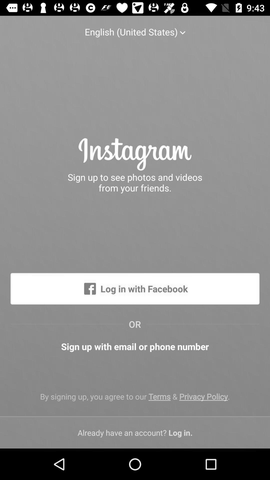

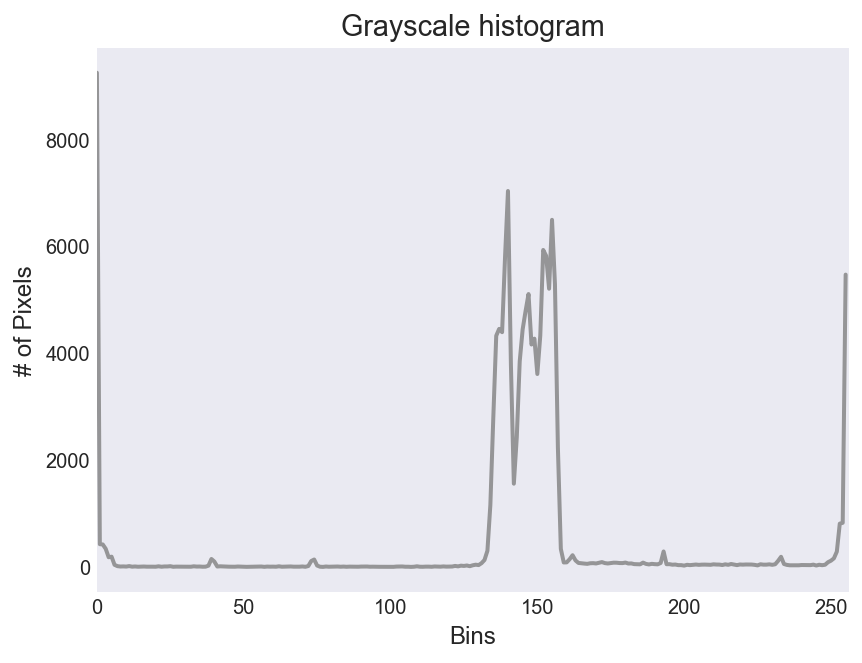

In [240]:
plot_ui_histogram(app_ui_exp.filename_exp[27560])

App UI


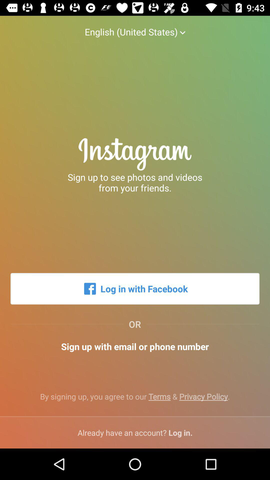

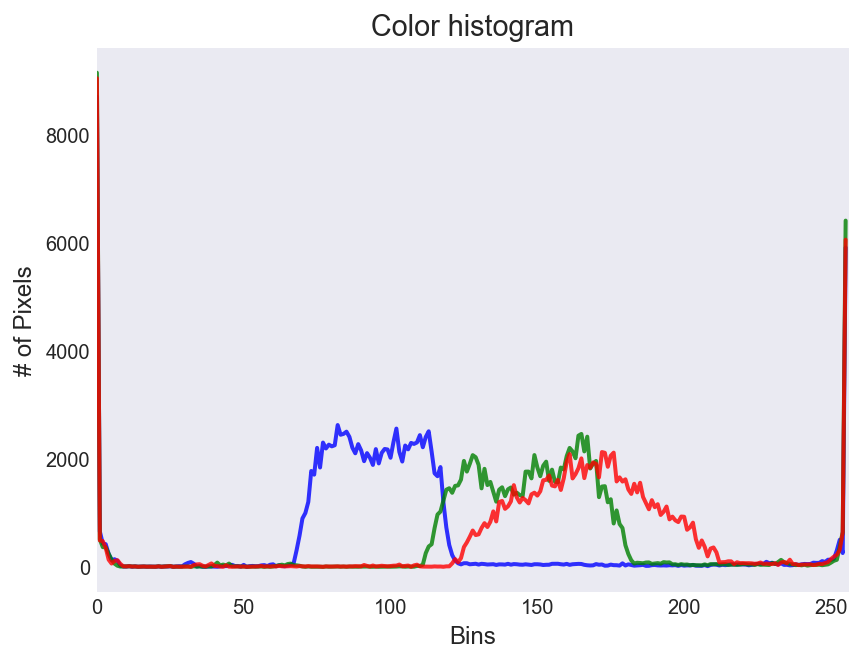

In [241]:
plot_ui_histogram(app_ui_exp.filename_exp[27560], color="color")

App UI


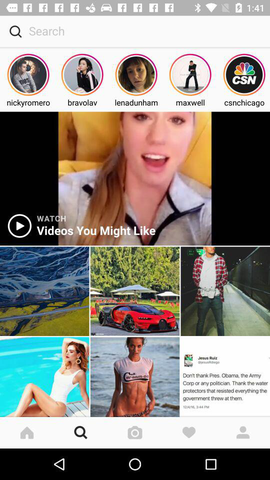

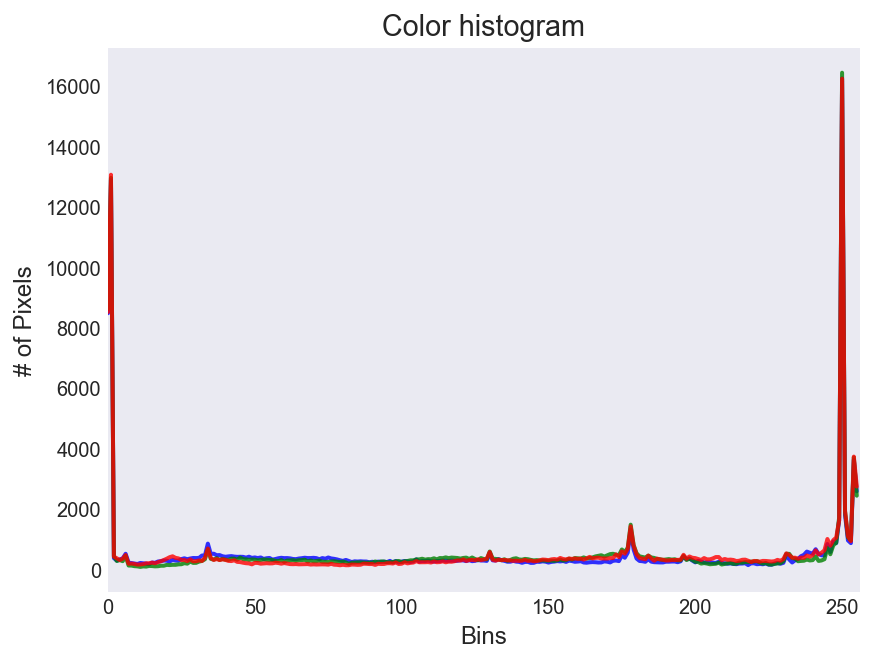

In [242]:
plot_ui_histogram(app_ui_exp.filename_exp[27552], color="color")

## Entropy 

Entropy with regards to image data looks at the "business" of an image, that is the amount of information which needs to be encoded by a compression algorithm. Images with very little contrast and large spans of pixels with the same values (for example an image of a dark sky) have low entropy. An image made up of a single color will have an entropy of zero. As a result, these images can be compressed to a relatively small size. The opposite is true of images with a great deal of contrast and color variance (for example an image of flamingos). These images have higher entropy and can't be compressed as much as low entropy images. 

#### scikit-image's Entropy "filter"
scikit-image's entropy is computed using base 2 logarithm. The "local" entropy looks at a given neighborhood in the image which is defined by a structurul element. The entropy filter then detects subtle variations in the local distribution of pixels.

In [192]:
image = np.array(pil_img(app_ui_exp.filename_exp[27560]).convert('L'))

In [193]:
# disk is 2-D array (the neighborhood expressed as a 2-D array of 1's and 0's)
skimage.filters.rank.entropy(image, disk(5))

array([[ 0.        ,  0.        ,  0.18312207, ...,  0.18312207,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.47563397, ...,  0.58601623,
         0.17925607,  0.        ],
       [ 0.        ,  0.31790122,  0.67955637, ...,  0.9792118 ,
         0.47563397,  0.36509898],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

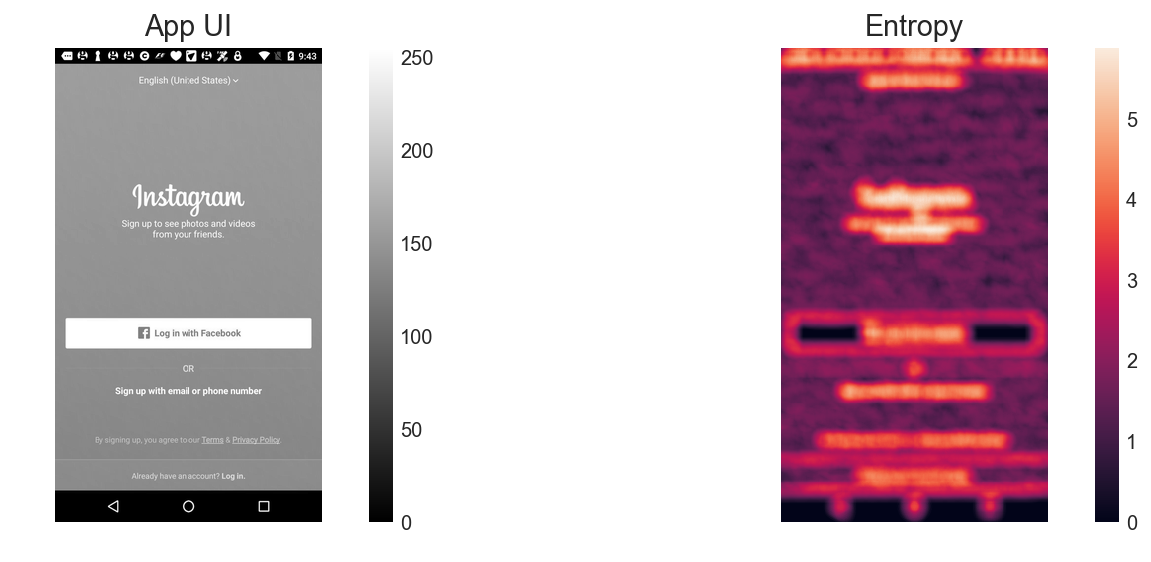

In [194]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True,
                               subplot_kw={"adjustable": "box-forced"})

img = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("App UI")
ax0.axis("off")
fig.colorbar(img, ax=ax0)

img1 = ax1.imshow(skimage.filters.rank.entropy(image, disk(10)))
ax1.set_title("Entropy")
ax1.axis("off")
fig.tight_layout()
fig.colorbar(img1, ax=ax1);

#### Create histogram data from UIs

In [190]:
# grayscale Instagram signup UI
ig1 = pil_img(app_ui_exp.filename_exp[27560]).convert('L').histogram()
# color Instagram signup UI
ig2 = pil_img(app_ui_exp.filename_exp[27560]).histogram()
# color Instagram feed view UI
ig3 = pil_img(app_ui_exp.filename_exp[27552]).histogram()

#### Roll my own entropy

H = -Σ p<sub>i</sub> • log<sub>2</sub>p<sub>i</sub>

In [195]:
def ui_entropy(vector):
    probabilities = [(float(i)/sum(vector)) for i in vector]
    return -sum([p * np.log2(p) for p in probabilities if p != 0])

In [235]:
# should color images be treated with joint entropy...? --> dit package

print('Entropy for Instagram grayscale signup UI = {0:.3f}'.format(ui_entropy(ig1)))
print('Entropy for Instagram color signup UI = {0:.3f}'.format(ui_entropy(ig2)))
print('Entropy for Instagram color feed view UI = {0:.3f}'.format(ui_entropy(ig3)))

Entropy for Instagram grayscale signup UI = 5.202
Entropy for Instagram color signup UI = 7.901
Entropy for Instagram color feed view UI = 8.351


#### Double check against SciPy's Entropy
pk, qk parameters, if only probabilities pk are given, the entropy is calculated. If qk is not None, then compute the KL divergence!

In [197]:
print(scipy.stats.entropy(ig1, base=2))
print(scipy.stats.entropy(ig2, base=2))
print(scipy.stats.entropy(ig3, base=2))

5.20156052118
7.90066030849
8.35109717551


#### KL divergence

Create separate histograms for each channel and compare to grayscale image pixel distribution.
Recall KL divergence is NOT symmetric!

In [ ]:
def rgb_histograms(filepath):
    img = pil_img(filepath)
    r, g, b = img.split()
    r_hist = r.histogram()
    g_hist = g.histogram()
    b_hist = b.histogram()
    return r_hist, g_hist, b_hist

ig2_ = rgb_histograms(app_ui_exp.filename_exp[27560])

In [212]:
len(ig1), len(ig2_[0])

(256, 256)

In [238]:
print('Between grayscale signup and only red channel signup UI = {0:.3f}'.format(scipy.stats.entropy(ig1, ig2_[0], base=2)))
print('Between grayscale signup and only green channel signup UI = {0:.3f}'.format(scipy.stats.entropy(ig1, ig2_[1], base=2)))
print('Between grayscale signup and only blue channel signup UI = {0:.3f}'.format(scipy.stats.entropy(ig1, ig2_[2], base=2)))

print()

print('Between red signup and green channel signup UI = {0:.3f}'.format(scipy.stats.entropy(ig2_[0], ig2_[1], base=2)))
print('Between red signup and blue channel signup UI = {0:.3f}'.format(scipy.stats.entropy(ig2_[0], ig2_[2], base=2)))
print('Between blue signup and green channel signup UI = {0:.3f}'.format(scipy.stats.entropy(ig2_[2], ig2_[1], base=2)))

print()

print('Between color signup and feed UI = {0:.3f}'.format(scipy.stats.entropy(ig2, ig3, base=2)))

Between grayscale signup and only red channel signup UI = 1.330
Between grayscale signup and only green channel signup UI = 1.153
Between grayscale signup and only blue channel signup UI = 5.327

Between red signup and green channel signup UI = 0.818
Between red signup and blue channel signup UI = 4.189
Between blue signup and green channel signup UI = 5.968

Between color signup and feed UI = 1.729
